In [1]:
import ee
ee.Authenticate()
ee.Initialize()

Enter verification code: 4/1AbUR2VNx-yHhfVft2X5jqMc50SuBbs9q3j8bUvfF3tjk8AhxJY1l31s0R3k

Successfully saved authorization token.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy import signal

# Step 1: Querying data

The study location is a rubber plantation in Guatamala. Location: https://geojson.io/#new&map=15.22/14.327577/-91.123068

First define a geometry as an region on interest and create a vector feature. Coordinates are in EPSG4326 by default (https://epsg.io/4326). 

In [3]:
roi_geom = ee.Geometry.Polygon([
    [-91.132, 14.334],
    [-91.132, 14.320],
    [-91.115, 14.320],
    [-91.115, 14.334],
    [-91.132, 14.334]
])

features = ee.FeatureCollection([
    ee.Feature(roi_geom, {'name': 'roi'})
])

Using MODIS data looking back to year 2000 (collection frequency of 1 to 2 days). 

The two data products are:
* MOD09GQ daily reflectance (https://developers.google.com/earth-engine/datasets/catalog/MODIS_061_MOD09GQ#bands)
* MOD09Q1 8 day composites of surface reflectance (https://developers.google.com/earth-engine/datasets/catalog/MODIS_061_MOD09Q1)

For simplicity use a single point (.centroid()), which returns a pixel value for each image in the filtered collection. This is to reduce the number of totals operations on GEE, which is limited to 5000 elements.

In [4]:
point = roi_geom.centroid()

filt_time = ee.Filter.date('2000-12-01', '2020-12-31')
filt_roi = ee.Filter.bounds(features)

mod09gq = ee.ImageCollection('MODIS/061/MOD09GQ')
mod09q1 = ee.ImageCollection('MODIS/061/MOD09Q1')

mod09gq_filt = (
    mod09gq
    .filter(filt_time)
    .filter(filt_roi)
)

mod09q1_filt = (
    mod09q1
    .filter(filt_time)
    .filter(filt_roi)
)

# Step 2: Map a function

In [5]:
def ndvi(image):
    value = image.normalizedDifference(
        ['sur_refl_b02', 'sur_refl_b01']).rename('ndvi')
    
    result = image.addBands(value).select('ndvi')
    
    return result

In [6]:
# use the ndvi function
mod09gq_ndvi = mod09gq_filt.map(ndvi)
mod09q1_ndvi = mod09q1_filt.map(ndvi)

# Step 3: Reduce

Using .getRegion: for each image the pixels that intersect the supplied geometry are returned from GEE to the client.

In [7]:
mod09gq_ndvi = mod09gq_ndvi.getRegion(point, scale=250).getInfo()
mod09q1_ndvi = mod09q1_ndvi.getRegion(point, scale=250).getInfo()
mod09gq_ndvi[:4] # First 4 rows

[['id', 'longitude', 'latitude', 'time', 'ndvi'],
 ['2000_12_01',
  -91.12397952697911,
  14.327005887601219,
  975628800000,
  0.8411795137092603],
 ['2000_12_02',
  -91.12397952697911,
  14.327005887601219,
  975715200000,
  0.8464084740152268],
 ['2000_12_03',
  -91.12397952697911,
  14.327005887601219,
  975801600000,
  0.8314525810324129]]

In [8]:
# convert data to dataframe
mod09gq_df = pd.DataFrame(mod09gq_ndvi[1:], columns=mod09gq_ndvi[0])
mod09q1_df = pd.DataFrame(mod09q1_ndvi[1:], columns=mod09q1_ndvi[0])

# modify
mod09gq_df.sort_values('time', inplace=True)
mod09q1_df.sort_values('time', inplace=True)

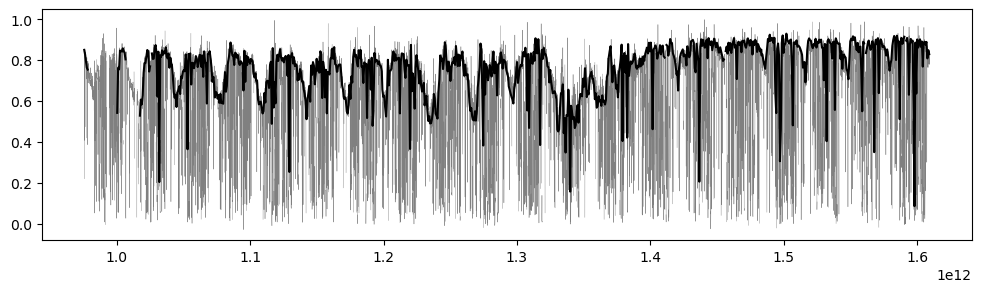

In [9]:
fig, ax = plt.subplots(figsize=(12, 3))

ax.plot(mod09gq_df['time'], mod09gq_df['ndvi'], lw=.3, c='gray')
ax.plot(mod09q1_df['time'], mod09q1_df['ndvi'], 'k-');

The graph shows the inherently noisy signal that comes from EO data. Cloud, haze, scattering in the atmosphere, and the difference in sun sensor geometry all affect the quality and consistency of measurements. The composite data, although much better than the daily observations, still contains errors and noise. A common method for smoothing out noise in EO time-series data is a Savitzky-Golay filter.

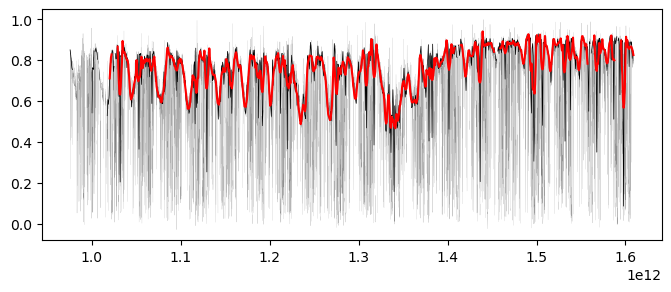

In [10]:
filter_mod09q1 = signal.savgol_filter(mod09q1_df['ndvi'], 9, 2)

fig, ax = plt.subplots(figsize=(8, 3))

ax.plot(mod09gq_df['time'], mod09gq_df['ndvi'], lw=.1, c='gray')
ax.plot(mod09q1_df['time'], mod09q1_df['ndvi'], 'k-', lw=.5)
ax.plot(mod09q1_df['time'], filter_mod09q1, 'r-');

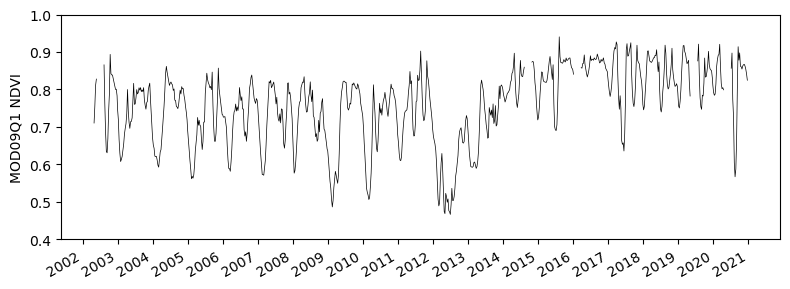

In [11]:
fig, ax = plt.subplots(figsize=(8, 3))

time_x = mod09q1_df['time'].astype('datetime64[ms]')

ax.plot(time_x, filter_mod09q1, 'k-', lw=.5)

# Labels and limits
ax.set_ylabel('MOD09Q1 NDVI')
ax.set_ylim((.4, 1))

loc = mdates.YearLocator()
ax.xaxis.set_major_locator(loc)

fig.autofmt_xdate()
fig.tight_layout()

# Exercise

What was the landcover before 2012? Can you find the temporal pattern in any of the landcovers close to the plantation? Add forest and grassland to your plot.

Steps: repeat the process for a different region and plot both roi and new on the same axes. 

Steps above are condensed into function stored in function_store.py

In [12]:
from function_store import filter_time_roi

#define roi and new region geometry
roi_geom = ee.Geometry.Polygon([
    [-91.132, 14.334],
    [-91.132, 14.320],
    [-91.115, 14.320],
    [-91.115, 14.334],
    [-91.132, 14.334]
])

roi_geom_new = ee.Geometry.Polygon([
            [-91.11924916286772,14.338875114002676],
            [-91.11924916286772,14.33207566075697],
            [-91.11326541606859,14.33207566075697],
            [-91.11326541606859,14.338875114002676],
            [-91.11924916286772,14.338875114002676]
])

roi_geom_fa = ee.Geometry.Polygon([
            [
              -91.13650947710093,
              14.314463808483879
            ],
            [
              -91.13650947710093,
              14.306744387674328
            ],
            [
              -91.12891832810136,
              14.306744387674328
            ],
            [
              -91.12891832810136,
              14.314463808483879
            ],
            [
              -91.13650947710093,
              14.314463808483879
            ]
          ])

#collect image
mod09q1 = ee.ImageCollection('MODIS/061/MOD09Q1')

#call function
roi_ndvi = filter_time_roi(roi_geom, mod09q1, '2000-12-01', '2020-12-31')
baseline_ndvi = filter_time_roi(roi_geom_new, mod09q1, '2000-12-01', '2020-12-31')
fa_ndvi = filter_time_roi(roi_geom_fa, mod09q1, '2000-12-01', '2020-12-31')

## Plot unfiltered and then filtered ndvi data

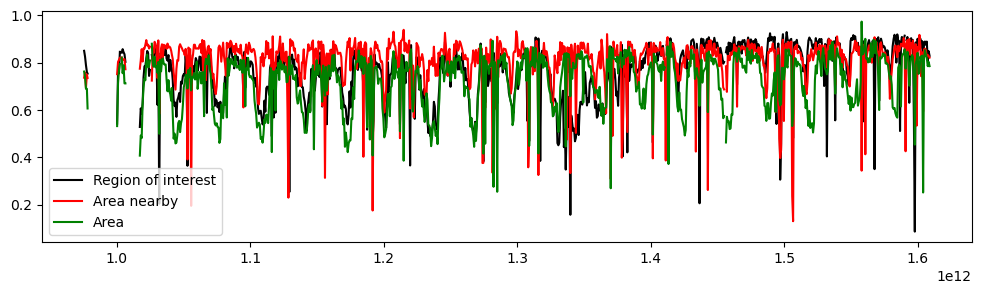

In [13]:
fig, ax = plt.subplots(figsize=(12, 3))

ax.plot(roi_ndvi['time'], roi_ndvi['ndvi'], 'k-', label ='Region of interest')
ax.plot(roi_ndvi['time'], baseline_ndvi['ndvi'], 'r-', label ='Area nearby')
ax.plot(roi_ndvi['time'], fa_ndvi['ndvi'], 'g-', label ='Area')
ax.legend();

In [14]:
#filter the ndvi signal using the savgol filter
filter_roi_ndvi = signal.savgol_filter(roi_ndvi['ndvi'], 9, 2)
filter_baseline_ndvi = signal.savgol_filter(baseline_ndvi['ndvi'], 9, 2)
filter_fa_ndvi = signal.savgol_filter(fa_ndvi['ndvi'], 9, 2)

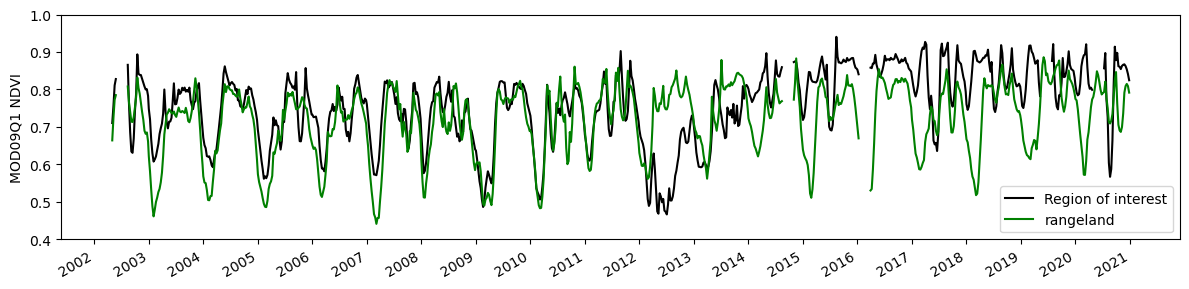

In [15]:
fig, ax = plt.subplots(figsize=(12, 3))

time_dates = roi_ndvi['time'].astype('datetime64[ms]')

ax.plot(time_dates, filter_roi_ndvi, 'k-', label ='Region of interest')
#ax.plot(time_dates, filter_baseline_ndvi, 'r-', label ='Area nearby')
ax.plot(time_dates, filter_fa_ndvi, 'g-', label ='rangeland')
ax.legend()

# Labels and limits
ax.set_ylabel('MOD09Q1 NDVI')
ax.set_ylim((.4, 1))

loc = mdates.YearLocator()
ax.xaxis.set_major_locator(loc)

fig.autofmt_xdate()
fig.tight_layout()

change this: 


After 2014, the signature of both regions is similar and the signature of 'area nearby' looks the same for the entire time series. Since we know that roi is a rubber plantation since 2013, this indicates that the area we selected nearby was likely a rubber plantation since 2002. 

 # Extra

In [16]:
collection = ee.ImageCollection('MODIS/061/MOD09GQ')

filtered = (
    collection
    .filter(ee.Filter.date('2018-12-01', '2019-12-31'))
    .filter(ee.Filter.bounds(features))
    #.filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))
    )

def get_values(image, feature_collection):
    '''Function to map to each image in a GEE collection'''
    ndvi = image.normalizedDifference(['sur_refl_b02', 'sur_refl_b01'])
    regions_fc = ndvi.reduceRegions(
        collection=feature_collection,
        reducer=ee.Reducer.mean(),
        scale=250,
    ).filter(ee.Filter.notNull(['mean'])) # drop nulls
    
    values =  regions_fc.reduceColumns(ee.Reducer.toList(), ['mean'])
    feat = ee.Feature(None, {# Must return a feature
        'ndvi': values.get('list'),
    })
    return feat

# lambda function because taking in two features
data = filtered.map(lambda image: get_values(image, features)).getInfo() 